# load model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [2]:
model=tf.keras.models.load_model('yolov3.h5')

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

# decode output from DarkNet

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.classes = classes
    def view(self):
        print('xmin:{} ymin:{}'.format(self.xmin,self.ymin))
        print('xmax:{} ymax:{}'.format(self.xmax,self.ymax))
        print('classes:{}'.format(self.classes))

In [6]:
def decode_netout(netout, anchors, threshold, net_h, net_w):
    '''
    netout: (grid_h, grid_w, #anchors*(x+y+w+h+p+#classes))
    achors: 3
    net_h=net_w=416 
    '''
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) #(grid_h,grid_w,3,85)
    nb_class = netout.shape[-1] - 5 #nb_class=80

    netout[..., :2]  = sigmoid(netout[..., :2]) #x,y
    netout[..., 4:]  = sigmoid(netout[..., 4:]) #p,C1,C2...,C80
    netout[..., 5:]  = np.expand_dims(netout[..., 4],axis=-1) * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > threshold
    
    boxes = []
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                
                p = netout[row][col][b][4]
                if p<threshold:
                    continue
                x, y, w, h = netout[row][col][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2*b] * np.exp(w) / net_w # unit: image width
                h = anchors[1+2*b] * np.exp(h) / net_h # unit: image height  
                classes = netout[int(row)][col][b][5:]
            
                boxes.append(BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, classes))

    return boxes

# Coordinate transform

In [7]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

# Non-max suppression

In [8]:
def iou(box_i,box_j):
    x1,y1=max(box_i.xmin,box_j.xmin),max(box_i.ymin,box_j.ymin)
    x2,y2=min(box_i.xmax,box_j.xmax),min(box_i.ymax,box_j.ymax)
    if x1>x2 or y1>y2:
        return 0
    intersect=(x2-x1)*(y2-y1)
    area_i=(box_i.xmax-box_i.xmin)*(box_i.ymax-box_i.ymin)
    area_j=(box_j.xmax-box_j.xmin)*(box_j.ymax-box_j.ymin)
    union=area_i+area_j-intersect
    return intersect/union

In [9]:
def do_nms(boxes,threshold):
    if len(boxes)==0:
        return
    dic={'person':0,'car':2} #by COCO dataset
    for name,c in dic.items():
        
        index_sort=np.argsort([-box.classes[c] for box in boxes]) #big->small
        for i in range(len(index_sort)):
            box_i=boxes[index_sort[i]]
            if box_i.classes[c]==0:
                continue
            for j in range(i+1,len(index_sort)):
                box_j=boxes[index_sort[j]]
                if iou(box_i,box_j)>threshold:
                    box_j.classes[c]=0

# draw BB

In [10]:
def get_boxes(boxes, threshold):
    dic={'person':0,'car':2} #by COCO dataset
    bbs=[] #[(lu,rd,name,score),(lu,rd,name,score),...]
    for box in boxes:
        for name,i in dic.items():
            if box.classes[i] > threshold:
                bbs.append(((box.xmin,box.ymin),(box.xmax,box.ymax),name,box.classes[i]*100))
                # don't break, many labels may trigger for one box
    return bbs

In [11]:
def draw_boxes(img,bbs):
    plt.figure()
    plt.imshow(img)
    axes=plt.gca()
    for bb in bbs:
        w,h=bb[1][0]-bb[0][0],bb[1][1]-bb[0][1]
        rect=patches.Rectangle(bb[0],w,h,linewidth=1,edgecolor='green',facecolor='none')
        axes.add_patch(rect)
    plt.show()

In [12]:
def load_image(path,shape=(416,416)):
    img=tf.keras.preprocessing.image.load_img(path)
    w,h=img.size
    img=tf.keras.preprocessing.image.load_img(path,target_size=shape)
    img=tf.keras.preprocessing.image.img_to_array(img,dtype=float)
    img=img/255.
    img=np.expand_dims(img,axis=0)
    return img,h,w

# test

In [13]:
filepath='road.jpg'

(1, 416, 416, 3)   1024   677


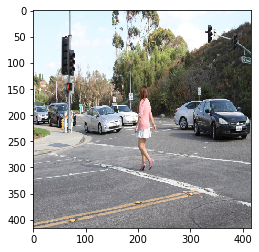

In [14]:
img,h,w=load_image(filepath)
print(img.shape,' ',w,' ',h)
plt.imshow(img[0]);

In [15]:
output=model.predict(img)
print([i.shape for i in output])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [16]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = []
for i in range(len(output)):
    boxes += decode_netout(output[i][0],anchors[i],0.5,416,416)

In [17]:
correct_yolo_boxes(boxes,h,w,416,416)

In [18]:
do_nms(boxes,0.5)

In [19]:
bbs=get_boxes(boxes,0.5)
bbs

[((751, 275), (1006, 407), 'car', 99.71743822097778),
 ((71, 290), (206, 369), 'car', 91.51557683944702),
 ((359, 294), (498, 360), 'car', 99.35304522514343),
 ((663, 277), (790, 369), 'car', 99.40537214279175),
 ((235, 296), (412, 387), 'car', 99.95179772377014),
 ((473, 239), (577, 503), 'person', 99.8511016368866),
 ((0, 293), (73, 354), 'car', 95.5792784690857)]

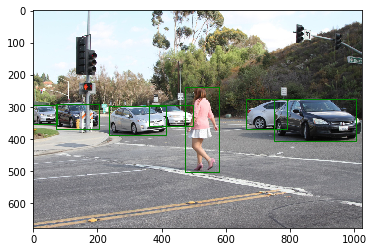

In [20]:
img=plt.imread(filepath)
draw_boxes(img,bbs)